## Expert Knowledge Worker

### A question answering agent that is an expert knowledge worker
### To be used by employees of Insurellm, an Insurance Tech company
### The agent needs to be accurate and the solution should be low cost.

This project will use RAG (Retrieval Augmented Generation) to ensure our question/answering assistant has high accuracy.

This first implementation will use a simple, brute-force type of RAG..

In [14]:
# imports

import os
import glob
from dotenv import load_dotenv
import gradio as gr

In [15]:
# imports for langchain, plotly and Chroma

from langchain.document_loaders import DirectoryLoader, TextLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_chroma import Chroma
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import plotly.graph_objects as go
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain
from langchain.embeddings import HuggingFaceEmbeddings

In [16]:
# price is a factor for our company, so we're going to use a low cost model

MODEL = "gpt-4o-mini"
db_name = "vector_db"

In [17]:
# Load environment variables in a file called .env

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')

In [18]:
# Read in documents using LangChain's loaders
# Take everything in all the sub-folders of our knowledgebase

folders = glob.glob("knowledge-base/*")

def add_metadata(doc, doc_type):
    doc.metadata["doc_type"] = doc_type
    return doc

# With thanks to CG and Jon R, students on the course, for this fix needed for some users 
text_loader_kwargs = {'encoding': 'utf-8'}
# If that doesn't work, some Windows users might need to uncomment the next line instead
# text_loader_kwargs={'autodetect_encoding': True}

documents = []
for folder in folders:
    doc_type = os.path.basename(folder)
    loader = DirectoryLoader(folder, glob="**/*.md", loader_cls=TextLoader, loader_kwargs=text_loader_kwargs)
    folder_docs = loader.load()
    documents.extend([add_metadata(doc, doc_type) for doc in folder_docs])

text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_documents(documents)

print(f"Total number of chunks: {len(chunks)}")
print(f"Document types found: {set(doc.metadata['doc_type'] for doc in documents)}")

Created a chunk of size 1088, which is longer than the specified 1000


Total number of chunks: 123
Document types found: {'employees', 'contracts', 'company', 'products'}


## A sidenote on Embeddings, and "Auto-Encoding LLMs"

We will be mapping each chunk of text into a Vector that represents the meaning of the text, known as an embedding.

OpenAI offers a model to do this, which we will use by calling their API with some LangChain code.

This model is an example of an "Auto-Encoding LLM" which generates an output given a complete input.
It's different to all the other LLMs we've discussed today, which are known as "Auto-Regressive LLMs", and generate future tokens based only on past context.

Another example of an Auto-Encoding LLMs is BERT from Google. In addition to embedding, Auto-encoding LLMs are often used for classification.

### Sidenote

In week 8 we will return to RAG and vector embeddings, and we will use an open-source vector encoder so that the data never leaves our computer - that's an important consideration when building enterprise systems and the data needs to remain internal.

In [19]:
# Put the chunks of data into a Vector Store that associates a Vector Embedding with each chunk
# Chroma is a popular open source Vector Database based on SQLLite

embeddings = OpenAIEmbeddings()

# If you would rather use the free Vector Embeddings from HuggingFace sentence-transformers
# Then replace embeddings = OpenAIEmbeddings()
# with:
# from langchain.embeddings import HuggingFaceEmbeddings
# embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# Delete if already exists

if os.path.exists(db_name):
    Chroma(persist_directory=db_name, embedding_function=embeddings).delete_collection()

# Create vectorstore

vectorstore = Chroma.from_documents(documents=chunks, embedding=embeddings, persist_directory=db_name)
print(f"Vectorstore created with {vectorstore._collection.count()} documents")

Vectorstore created with 123 documents


In [20]:
# Let's investigate the vectors

collection = vectorstore._collection
count = collection.count()

sample_embedding = collection.get(limit=1, include=["embeddings"])["embeddings"][0]
dimensions = len(sample_embedding)
print(f"There are {count:,} vectors with {dimensions:,} dimensions in the vector store")

There are 123 vectors with 1,536 dimensions in the vector store


## Visualizing the Vector Store

Let's take a minute to look at the documents and their embedding vectors to see what's going on.

In [21]:
# Prework (with thanks to Jon R for identifying and fixing a bug in this!)

result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
metadatas = result['metadatas']
doc_types = [metadata['doc_type'] for metadata in metadatas]
colors = [['blue', 'green', 'red', 'orange'][['products', 'employees', 'contracts', 'company'].index(t)] for t in doc_types]

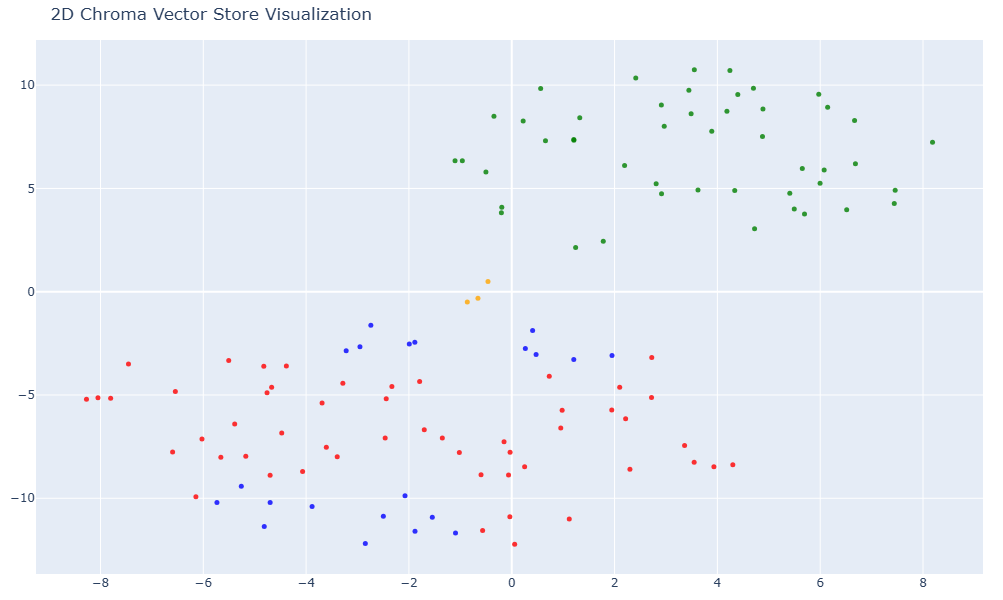

In [22]:
# We humans find it easier to visalize things in 2D!
# Reduce the dimensionality of the vectors to 2D using t-SNE
# (t-distributed stochastic neighbor embedding)

tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 2D scatter plot
fig = go.Figure(data=[go.Scatter(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='2D Chroma Vector Store Visualization',
    scene=dict(xaxis_title='x',yaxis_title='y'),
    width=800,
    height=600,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

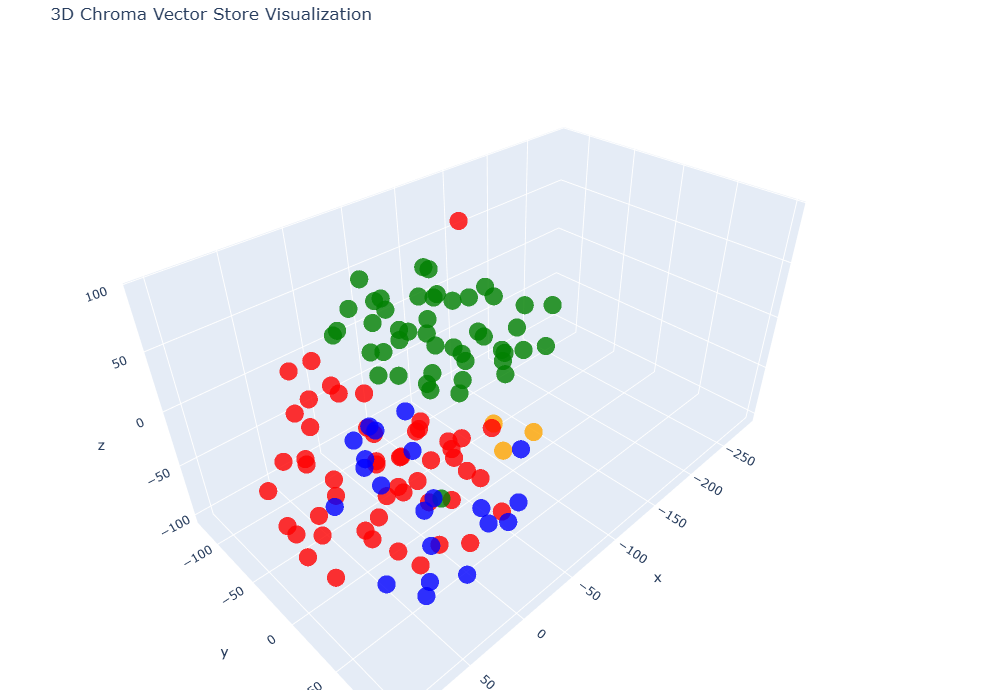

In [23]:
# Let's try 3D!

tsne = TSNE(n_components=3, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    z=reduced_vectors[:, 2],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='3D Chroma Vector Store Visualization',
    scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'),
    width=900,
    height=700,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

## Time to use LangChain to bring it all together

In [24]:
# create a new Chat with OpenAI
llm = ChatOpenAI(temperature=0.7, model_name=MODEL)

# Alternative - if you'd like to use Ollama locally, uncomment this line instead
# llm = ChatOpenAI(temperature=0.7, model_name='llama3.2', base_url='http://localhost:11434/v1', api_key='ollama')

# set up the conversation memory for the chat
memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)

# the retriever is an abstraction over the VectorStore that will be used during RAG
retriever = vectorstore.as_retriever()

# putting it together: set up the conversation chain with the GPT 3.5 LLM, the vector store and memory
conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory)

In [25]:
# Let's try a simple question

query = "Please explain what Insurellm is in a couple of sentences"
result = conversation_chain.invoke({"question": query})
print(result["answer"])

Insurellm is an innovative insurance tech firm founded in 2015 that offers a range of software products designed to enhance the insurance industry. With 200 employees and over 300 clients worldwide, its key products include portals for auto and home insurance companies, an enterprise platform for reinsurance, and a marketplace connecting consumers with insurance providers.


In [26]:
# set up a new conversation memory for the chat
memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)

# putting it together: set up the conversation chain with the GPT 4o-mini LLM, the vector store and memory
conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory)

## Now we will bring this up in Gradio using the Chat interface -

A quick and easy way to prototype a chat with an LLM

In [27]:
# Wrapping that in a function

def chat(question, history):
    result = conversation_chain.invoke({"question": question})
    return result["answer"]

In [28]:
# And in Gradio:

view = gr.ChatInterface(chat, type="messages").launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7863
* To create a public link, set `share=True` in `launch()`.


In [29]:
# Let's investigate what gets sent behind the scenes

# LangChain의 Background에서 어떤 작업이 이루어지는지 출력
from langchain_core.callbacks import StdOutCallbackHandler

llm = ChatOpenAI(temperature=0.7, model_name=MODEL)

memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)

retriever = vectorstore.as_retriever()

conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory, callbacks=[StdOutCallbackHandler()])

query = "Who received the prestigious IIOTY award in 2023?"
result = conversation_chain.invoke({"question": query})
answer = result["answer"]
print("\nAnswer:", answer)



> Entering new ConversationalRetrievalChain chain...


> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
System: Use the following pieces of context to answer the user's question.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
----------------
- **2022**: **Satisfactory**  
  Avery focused on rebuilding team dynamics and addressing employee concerns, leading to overall improvement despite a saturated market.  

- **2023**: **Exceeds Expectations**  
  Market leadership was regained with innovative approaches to personalized insurance solutions. Avery is now recognized in industry publications as a leading voice in Insurance Tech innovation.

## Annual Performance History
- **2020:**  
  - Completed onboarding successfully.  
  - Met expectations in delivering project milestones.  
  - Received positive feedback from the team leads.

- **2021:**  
  - Achieved a 95% success rate in proje

In [30]:
# create a new Chat with OpenAI
llm = ChatOpenAI(temperature=0.7, model_name=MODEL)

# set up the conversation memory for the chat
memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)

# the retriever is an abstraction over the VectorStore that will be used during RAG; k is how many chunks to use
retriever = vectorstore.as_retriever(search_kwargs={"k": 25})

# putting it together: set up the conversation chain with the GPT 3.5 LLM, the vector store and memory
conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory)

In [31]:
def chat(question, history):
    result = conversation_chain.invoke({"question": question})
    return result["answer"]

In [32]:
view = gr.ChatInterface(chat, type="messages").launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7864
* To create a public link, set `share=True` in `launch()`.


# Exercises

Try applying this to your own folder of data, so that you create a personal knowledge worker, an expert on your own information!

In [33]:
# Let's investigate what gets sent behind the scenes

# LangChain의 Background에서 어떤 작업이 이루어지는지 출력
from langchain_core.callbacks import StdOutCallbackHandler

llm = ChatOpenAI(temperature=0.7, model_name=MODEL)

memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)

retriever = vectorstore.as_retriever(search_kwargs={"k": 25})

conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory, callbacks=[StdOutCallbackHandler()])

query = "Who received the prestigious IIOTY award in 2023?"
result = conversation_chain.invoke({"question": query})
answer = result["answer"]
print("\nAnswer:", answer)



> Entering new ConversationalRetrievalChain chain...


> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
System: Use the following pieces of context to answer the user's question.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
----------------
- **2022**: **Satisfactory**  
  Avery focused on rebuilding team dynamics and addressing employee concerns, leading to overall improvement despite a saturated market.  

- **2023**: **Exceeds Expectations**  
  Market leadership was regained with innovative approaches to personalized insurance solutions. Avery is now recognized in industry publications as a leading voice in Insurance Tech innovation.

## Annual Performance History
- **2020:**  
  - Completed onboarding successfully.  
  - Met expectations in delivering project milestones.  
  - Received positive feedback from the team leads.

- **2021:**  
  - Achieved a 95% success rate in proje

In [43]:
# chunk의 최대 길이를 늘림
documents = []
for folder in folders:
    doc_type = os.path.basename(folder)
    loader = DirectoryLoader(folder, glob="**/*.md", loader_cls=TextLoader, loader_kwargs=text_loader_kwargs)
    folder_docs = loader.load()
    documents.extend([add_metadata(doc, doc_type) for doc in folder_docs])

text_splitter = CharacterTextSplitter(chunk_size=2000, chunk_overlap=400)
chunks = text_splitter.split_documents(documents)

In [46]:
llm = ChatOpenAI(temperature=0.7, model_name=MODEL)

memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)

retriever = vectorstore.as_retriever(search_kwargs={"k": 20})

conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory)

query = "Who received the prestigious IIOTY award in 2023?"
result = conversation_chain.invoke({"question": query})
answer = result["answer"]
print("\nAnswer:", answer)


Answer: Maxine received the prestigious IIOTY 2023 award.
